# 跨数据集的糖尿病预测模型建模与对比研究

## 数据查看区分

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

In [2]:
df = pd.read_csv("C:/Users/86156/Desktop/任务分配&原数据/diabetes_prediction_dataset.csv")
#根据自身文件保存地址更改，注意斜杠的更改
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
# 样本数量 & 字段数量
print("数据维度:", df.shape)

数据维度: (100000, 9)


In [4]:
# 缺失值检查
print("缺失值数量:")
print(df.isnull().sum())

缺失值数量:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [5]:
# 数据类型
print("字段类型:")
print(df.dtypes)

字段类型:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [6]:
# 查看数值型字段的分布
df.describe()
#可以看出bmi的数据显著出现异常值

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


## 探索性数据分析

In [7]:
df['gender'].value_counts(normalize=True)

Female    0.58552
Male      0.41430
Other     0.00018
Name: gender, dtype: float64

In [8]:
df1 = df[df['gender'] != 'Other'].copy()
df1['gender'] = df1['gender'].replace({'Male': 1, 'Female': 0})
df1['gender'].value_counts(normalize=True)

0    0.585625
1    0.414375
Name: gender, dtype: float64

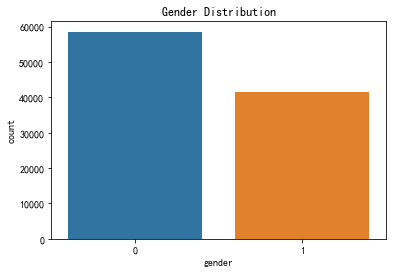

In [9]:
#性别比例为6：4，在可以接受的范围内
sns.countplot(x='gender', data=df1)
plt.title("Gender Distribution")
plt.show()

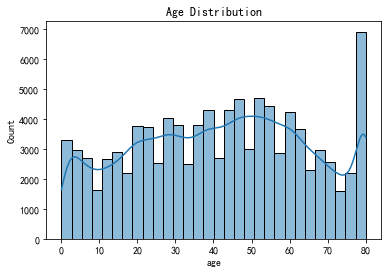

In [10]:
sns.histplot(df1['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()
#年龄数据在高龄需后期与是否患病进行进一步判断探索

In [11]:
#根据建模方式不同，逻辑回归处理建议对各数据分类判断进行进行标准化归一化处理，提高鲁棒性，随机森林不做处理
#高血压心脏病数据，0未患病，1患病，不做处理

In [12]:
df1['smoking_history'].value_counts(normalize=True)

No Info        0.358164
never          0.350983
former         0.093537
current        0.092877
not current    0.064402
ever           0.040037
Name: smoking_history, dtype: float64

In [13]:
df1['smoking_history'] = df1['smoking_history'].replace({'never': 0, 'former': 1,'not current': 1,'ever': 1, 'current': 2,'No Info': 3})
df1['smoking_history'].value_counts(normalize=True)

3    0.358164
0    0.350983
1    0.197976
2    0.092877
Name: smoking_history, dtype: float64

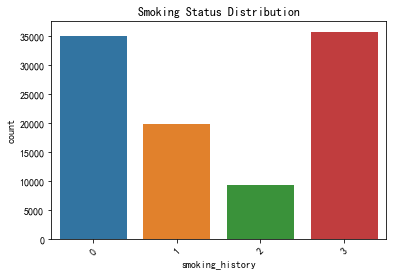

In [14]:
sns.countplot(x='smoking_history', data=df1)
plt.title("Smoking Status Distribution")
plt.xticks(rotation=45)
plt.show()

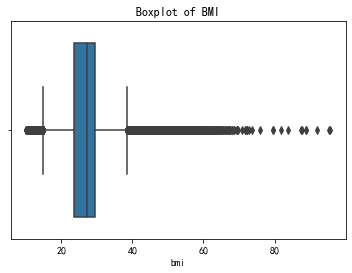

In [15]:
sns.boxplot(x=df1['bmi'])
plt.title("Boxplot of BMI")
plt.show()

<ipython-input-16-7f389afb63f4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[(df['bmi'] >= 12) & (df['bmi'] <= 60)]


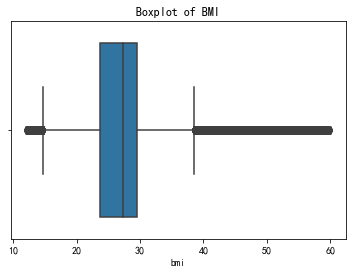

In [16]:
#通过探索性查看以及查询相关知识，可以得知bmi的异常值较多，进行删除处理
df1 = df1[(df['bmi'] >= 12) & (df['bmi'] <= 60)]
sns.boxplot(x=df1['bmi'])
plt.title("Boxplot of BMI")
plt.show()

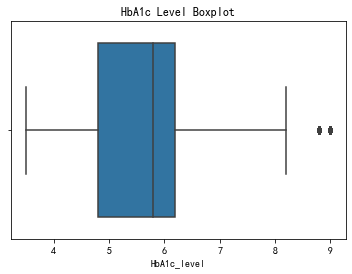

In [17]:
sns.boxplot(x=df1['HbA1c_level'])
plt.title("HbA1c Level Boxplot")
plt.show()

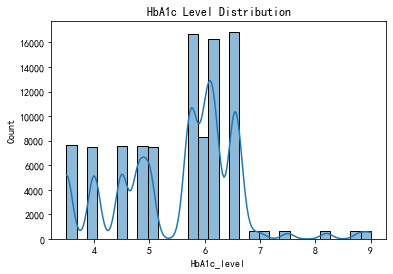

In [18]:
sns.histplot(df1['HbA1c_level'], bins=30, kde=True)
plt.title("HbA1c Level Distribution")
plt.show()

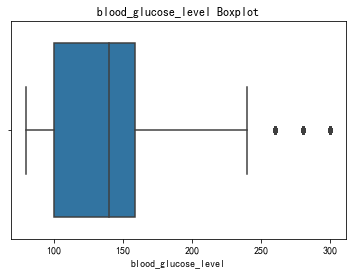

In [19]:
sns.boxplot(x=df1['blood_glucose_level'])
plt.title("blood_glucose_level Boxplot")
plt.show()

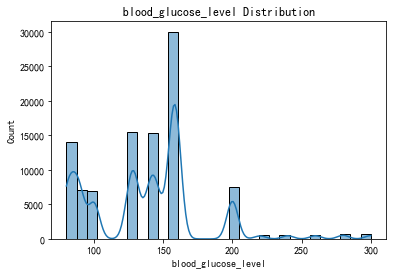

In [20]:
sns.histplot(df1['blood_glucose_level'], bins=30, kde=True)
plt.title("blood_glucose_level Distribution")
plt.show()

In [21]:
#以上，初步异常值检查完成，少量异常值暂做保留处理，若对逻辑回归的产生影响，建议删除处理

## 单变量分析

### 连续型特征分析

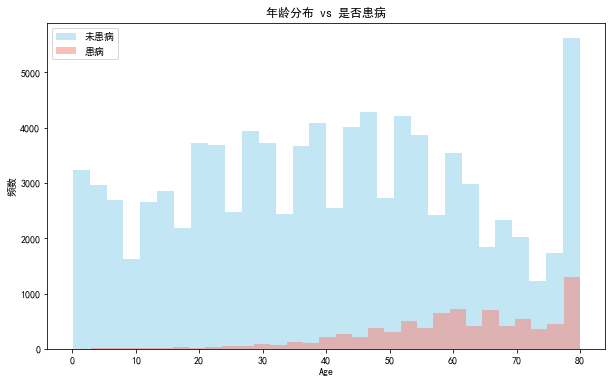

In [22]:
#年龄
plt.figure(figsize=(10, 6))
df1[df1['diabetes'] == 0]['age'].plot(kind='hist', bins=30, alpha=0.5, label='未患病', color='skyblue')
df1[df1['diabetes'] == 1]['age'].plot(kind='hist', bins=30, alpha=0.5, label='患病', color='salmon')
plt.legend()
plt.title('年龄分布 vs 是否患病')
plt.xlabel('Age')
plt.ylabel('频数')
plt.show()

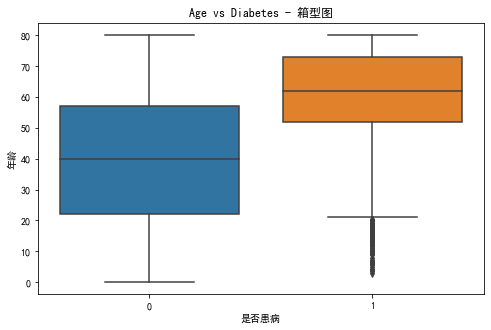

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='diabetes', y='age', data=df1)
plt.title('Age vs Diabetes - 箱型图')
plt.xlabel('是否患病')
plt.ylabel('年龄')
plt.show()

In [24]:
group0 = df1[df1['diabetes'] == 0]['age']
group1 = df1[df1['diabetes'] == 1]['age']

stat, p = mannwhitneyu(group0, group1)
print(f"年龄与是否患病的U检验 p值为: {p:.4f}")

年龄与是否患病的U检验 p值为: 0.0000


In [25]:
#在单变量分析中，年龄作为连续变量，其分布在患病组与未患病组中呈现出极显著差异（p < 0.0001）
#表明该变量对于糖尿病预测具有较强的判别力。
#但考虑到数据集中变量分布理想化程度较高，可能存在采集偏倚或样本筛选的问题，需在泛化模型时加以注意。

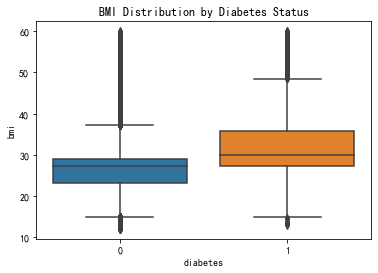

In [26]:
#bmi
sns.boxplot(data=df1, x='diabetes', y='bmi')
plt.title("BMI Distribution by Diabetes Status")
plt.show()

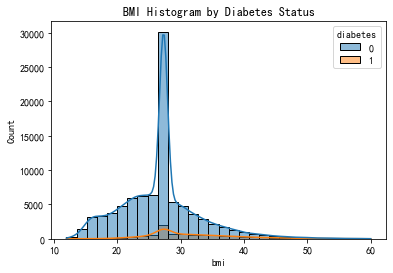

In [27]:
sns.histplot(data=df1, x='bmi', hue='diabetes', kde=True, bins=30)
plt.title("BMI Histogram by Diabetes Status")
plt.show()

In [28]:
bmi_0 = df1[df1['diabetes'] == 0]['bmi']
bmi_1 = df1[df1['diabetes'] == 1]['bmi']

stat, p = mannwhitneyu(bmi_0, bmi_1)
print(f"U检验的p值为: {p}")

U检验的p值为: 0.0


In [29]:
#对 BMI 变量进行分析发现，患病组的 BMI 均值略高于未患病组，箱型图显示其分布存在一定差异。
#进一步使用 Mann-Whitney U 检验，p 值为0，说明该变量在两组间差异具有统计学意义，可作为模型特征之一。

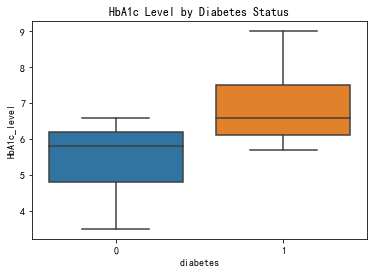

In [30]:
#HbA1c_level
sns.boxplot(x='diabetes', y='HbA1c_level', data=df1)
plt.title('HbA1c Level by Diabetes Status')
plt.show()

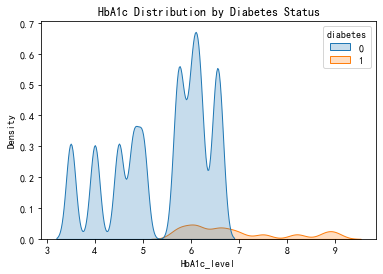

In [31]:
sns.kdeplot(data=df1, x='HbA1c_level', hue='diabetes', fill=True)
plt.title('HbA1c Distribution by Diabetes Status')
plt.show()

In [32]:
diabetes_yes = df1[df1['diabetes'] == 1]['HbA1c_level']
diabetes_no = df1[df1['diabetes'] == 0]['HbA1c_level']

stat, p = mannwhitneyu(diabetes_yes, diabetes_no)
print(f'Mann-Whitney U test: stat={stat}, p={p}')

Mann-Whitney U test: stat=648131514.0, p=0.0


In [33]:
#由图像可得，未患病人群糖化血红蛋白高于患病人群，由p值也可得出显著性结论，可以作为保留特征

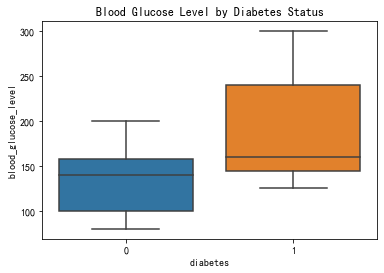

In [34]:
#blood_glucose_level
# 箱型图
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df1)
plt.title('Blood Glucose Level by Diabetes Status')
plt.show()

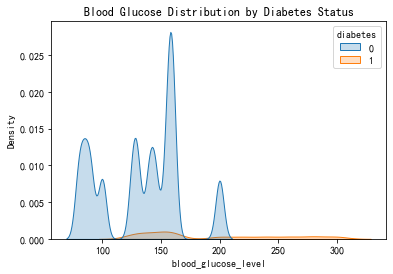

In [35]:
# KDE 密度图
sns.kdeplot(data=df1, x='blood_glucose_level', hue='diabetes', fill=True)
plt.title('Blood Glucose Distribution by Diabetes Status')
plt.show()

In [36]:
glu_yes = df1[df1['diabetes'] == 1]['blood_glucose_level']
glu_no = df1[df1['diabetes'] == 0]['blood_glucose_level']

stat, p = mannwhitneyu(glu_yes, glu_no)
print(f'Mann-Whitney U test: stat={stat}, p={p}')

Mann-Whitney U test: stat=604878899.0, p=0.0


### 分类型变量

In [37]:
#gender
# 交叉表
gender_crosstab = pd.crosstab(df1['gender'], df1['diabetes'], normalize='index')
print(gender_crosstab)

diabetes         0         1
gender                      
0         0.924181  0.075819
1         0.902575  0.097425


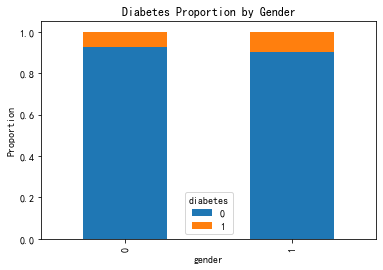

In [38]:
# 条形图
gender_crosstab.plot(kind='bar', stacked=True)
plt.title('Diabetes Proportion by Gender')
plt.ylabel('Proportion')
plt.show()

In [39]:
# 原始频数交叉表
contingency = pd.crosstab(df1['gender'], df1['diabetes'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f'Chi-square test: chi2={chi2}, p={p}')

Chi-square test: chi2=145.42393865383696, p=1.7349155462960127e-33


In [40]:
#存在显著性关系，特征保留

In [41]:
#hypertension
# 构建交叉表
ct = pd.crosstab(df1['hypertension'], df1['diabetes'])
print(ct)

diabetes          0     1
hypertension             
0             85940  6381
1              5385  2078


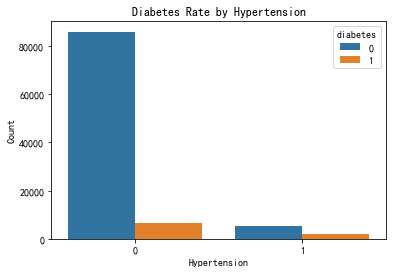

In [42]:
# 可视化：条形图
sns.countplot(x='hypertension', hue='diabetes', data=df1)
plt.title("Diabetes Rate by Hypertension")
plt.xlabel("Hypertension")
plt.ylabel("Count")
plt.show()

In [43]:
# 进行卡方检验
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi2 = {chi2}, p = {p}")

Chi2 = 3896.714251312905, p = 0.0


In [44]:
#heart_disease
# 构建交叉表
ct = pd.crosstab(df1['heart_disease'], df1['diabetes'])
print(ct)

diabetes           0     1
heart_disease             
0              88653  7196
1               2672  1263


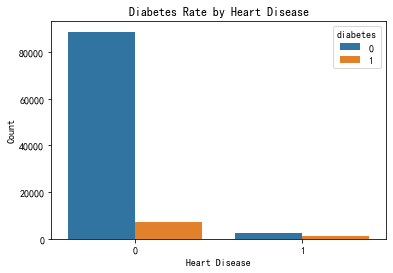

In [45]:
# 可视化：条形图
sns.countplot(x='heart_disease', hue='diabetes', data=df1)
plt.title("Diabetes Rate by Heart Disease")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()

In [46]:
# 进行卡方检验
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi2 = {chi2}, p = {p}")

Chi2 = 2942.36320397526, p = 0.0


In [47]:
#smoking_history
df_smoking = df1[df1['smoking_history'] != 3]
# 交叉表
ct = pd.crosstab(df_smoking['smoking_history'], df_smoking['diabetes'])
print(ct)

diabetes             0     1
smoking_history             
0                31702  3325
1                17025  2745
2                 8328   942


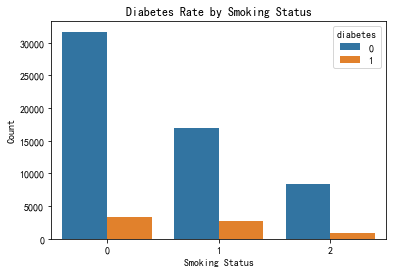

In [48]:
# 可视化
sns.countplot(x='smoking_history', hue='diabetes', data=df_smoking)
plt.title("Diabetes Rate by Smoking Status")
plt.xlabel("Smoking Status")
plt.ylabel("Count")
plt.show()

In [49]:
# 卡方检验
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi2 = {chi2}, p = {p}")

Chi2 = 256.91484478043856, p = 1.6279846152560488e-56


In [50]:
#因SmokingStatus字段中‘No Info’占比达30%以上，作为不可判定类，故在进行与糖尿病状态的关系分析时暂不计入主分析，另行讨论
df2 = df1[df1['smoking_history'] != 3]
print("数据维度:", df2.shape)

#综上所述，8个字段皆对结果具有显著性影响

数据维度: (64067, 9)


## 特征间相关性分析

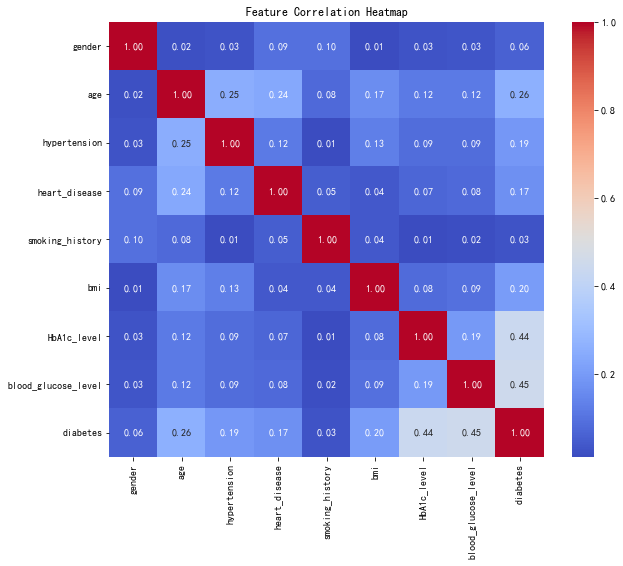

In [51]:
# 选出数值型字段
numeric_cols = df2.select_dtypes(include=['float64', 'int64']).columns

# 计算相关系数矩阵
corr_matrix = df2[numeric_cols].corr(method='pearson')

# 可视化
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [52]:
#特征间无强相关性，冗余风险较低

In [53]:
# 假设 y 是目标变量，X 是特征矩阵
X = df2.drop(columns=['diabetes'])
X = add_constant(X)  # 加常数项
# 计算 VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,50.467114
1,gender,1.018341
2,age,1.158112
3,hypertension,1.086645
4,heart_disease,1.077095
5,smoking_history,1.016656
6,bmi,1.045685
7,HbA1c_level,1.055449
8,blood_glucose_level,1.057784


In [54]:
#特征间无共线性，无冗余重复信息，可以全部参与模型训练

## 随机森林建模

In [55]:
# 拆分特征和目标
X = df2.drop(columns=['diabetes'])
y = df2['diabetes']

# 拆分训练集和测试集（8：2）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化模型
rf_model = RandomForestClassifier(random_state=42)

# 拟合模型
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# 预测
y_pred = rf_model.predict(X_test)

# 准确率
print("准确率:", accuracy_score(y_test, y_pred))

准确率: 0.9613703761510848


In [57]:
# 混淆矩阵
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred))

混淆矩阵:
 [[11382    51]
 [  444   937]]


In [58]:
# 分类报告
print("分类报告:\n", classification_report(y_test, y_pred))
#召回率在医学样本中较低，需要改进

分类报告:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     11433
           1       0.95      0.68      0.79      1381

    accuracy                           0.96     12814
   macro avg       0.96      0.84      0.88     12814
weighted avg       0.96      0.96      0.96     12814



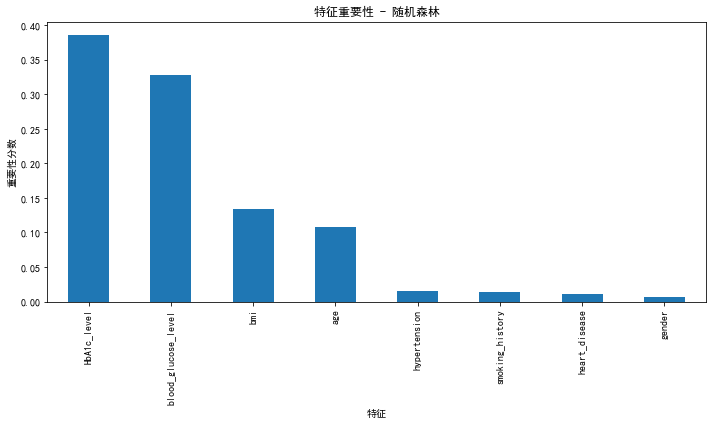

In [59]:
# 提取特征重要性
importances = rf_model.feature_importances_
features = X.columns

# 排序
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

# 可视化
plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar')
plt.title("特征重要性 - 随机森林")
plt.ylabel("重要性分数")
plt.xlabel("特征")
plt.tight_layout()
plt.show()

In [60]:
# 添加 class_weight 惩罚项
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [61]:
# 获取预测概率（注意是正类的概率）
y_probs = rf_model.predict_proba(X_test)[:, 1]  # 取患病为1的那一列

# 自定义阈值
threshold = 0.31
y_pred_custom = (y_probs >= threshold).astype(int)

# 混淆矩阵 + 分类报告
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_custom))
print("分类报告:\n", classification_report(y_test, y_pred_custom))

# AUC得分（衡量整体分数能力）
print("AUC得分:", roc_auc_score(y_test, y_probs))

#患病样本召回率提高
#根据多次调试参数，以及考虑到预测糖尿病的目的，阈值为0.31时，召回率和准确率能达到较为满意的水平

混淆矩阵:
 [[11157   276]
 [  347  1034]]
分类报告:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     11433
           1       0.79      0.75      0.77      1381

    accuracy                           0.95     12814
   macro avg       0.88      0.86      0.87     12814
weighted avg       0.95      0.95      0.95     12814

AUC得分: 0.9621332875798826


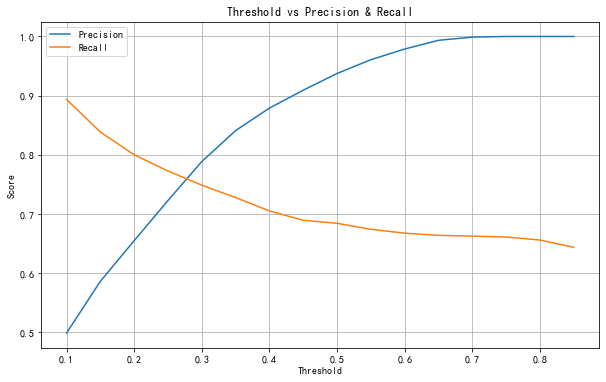

In [62]:
thresholds = np.arange(0.1, 0.9, 0.05)
precisions = []
recalls = []

for t in thresholds:
    y_pred_temp = (y_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_temp))
    recalls.append(recall_score(y_test, y_pred_temp))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision & Recall')
plt.legend()
plt.grid(True)
plt.show()

## 泛化能力测试（未找到合适数据，暂时中止）

### 字段对齐

### 数据清洗